In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.special import gamma, digamma

In [3]:
def compute_KL(a1, b1, a2, b2):  # Note: KL divergence is not symmetric
    # Compute normalization function
    B_a1b1 = gamma(a1) * gamma(b1) / gamma(a1 + b1)
    B_a2b2 = gamma(a2) * gamma(b2) / gamma(a2 + b2)
    term0 = np.log(B_a2b2 / B_a1b1)
    term1 = (a1 - a2) * digamma(a1)
    term2 = (b1 - b2) * digamma(b1)
    term3 = (a2 - a1 + b2 - b1) * digamma(a1 + b1)
    all = term0 + term1 + term2 + term3
    return all

In [4]:
# Load results
path = "./sim_multisource_bin/sweep_results/"

baseline_all = pd.DataFrame()
proposed_all = pd.DataFrame()

for i in range(10):
    baseline_df = pd.read_csv(path + f"sweep_baseline_seed_{i}.csv")
    baseline_df["seed"] = i
    baseline_all = pd.concat([baseline_all, baseline_df])
    proposed_df = pd.read_csv(path + f"sweep_proposed_fixscale_seed_{i}.csv")
    proposed_df["seed"] = i
    proposed_all = pd.concat([proposed_all, proposed_df])

baseline_all.loc[
    baseline_all["approach"] == "multisource uniform", "approach"
] = "Avg-ERM"
baseline_all.loc[baseline_all["approach"] == "multisource cat", "approach"] = (
    "Cat-ERM"
)
baseline_all.loc[
    baseline_all["approach"] == "multisource simple adapt", "approach"
] = "SA"

oracle = baseline_all[baseline_all["approach"] == "ERM"][
    ["approach", "target -> target", "pU=0", "seed"]
]
oracle.loc[oracle["approach"] == "ERM", "approach"] = "ORACLE"
oracle = oracle.rename(columns={"target -> target": "MSE"})

baseline_all = baseline_all.drop("source -> source", axis=1)
baseline_all = baseline_all.drop("target -> target", axis=1)
baseline_all = baseline_all.drop("target -> source", axis=1)
baseline_all = baseline_all.rename(columns={"source -> target": "MSE"})

proposed_all.loc[proposed_all["task"] == "adaptation", "task"] = "Proposed"

all_summary = proposed_all[proposed_all["task"] == "Proposed"]
all_summary = all_summary.rename(
    columns={"predict error.l2": "MSE", "task": "approach"}
)
all_summary = all_summary.drop("env_id", axis=1)

all_summary = pd.concat([all_summary, baseline_all, oracle])

In [5]:
all_df = pd.DataFrame()
change_name = {
    "ERM": "ERM",
    "multisource uniform": "Avg-ERM",
    "multisource cat": "Cat-ERM",
    "multisource simple aadapt": "SA",
}

path = "./sim_multisource_cont/sweep_results/"

for i in range(10):
    df_proposed = pd.read_csv(path + f"sweep_proposed_fixscale_seed_{i}.csv")
    df_baseline = pd.read_csv(path + f"sweep_baseline_seed_{i}.csv")
    for item in df_proposed[df_proposed["task"] == "adaptation"].values:
        a1 = item[3]
        b1 = item[4]
        d1 = compute_KL(a1, b1, 2, 4)
        d2 = compute_KL(a1, b1, 4, 2)
        diff = (
            item[2]
            - df_proposed[
                (df_proposed["task"] == "target-target")
                & (df_proposed["a"] == item[3])
                & (df_proposed["b"] == item[4])
            ]["predict error.l2"].values[0]
        )
        diff2 = (
            item[2]
            - df_baseline[
                (df_baseline["approach"] == "ERM")
                & (df_baseline["a"] == item[3])
                & (df_baseline["b"] == item[4])
            ]["target -> target"].values[0]
        )
        new_dict = {
            "approach": "Proposed",
            "MSE": item[2],
            "a": item[3],
            "b": item[4],
            "kl1": d1,
            "kl2": d2,
            "offset": diff,
            "offset2": diff2,
            "seed": i,
        }

        all_df = pd.concat(
            [all_df, pd.DataFrame.from_dict([new_dict])], ignore_index=True
        )

    for approach in [
        "ERM",
        "COVAR",
        "LABEL",
        "multisource uniform",
        "multisource cat",
        "multisource simple aadapt",
    ]:
        for item in df_baseline[df_baseline["approach"] == approach].values:
            a1 = item[5]
            b1 = item[6]
            d1 = compute_KL(a1, b1, 2, 4)
            d2 = compute_KL(a1, b1, 4, 2)
            diff = (
                item[2]
                - df_proposed[
                    (df_proposed["task"] == "target-target")
                    & (df_proposed["a"] == a1)
                    & (df_proposed["b"] == b1)
                ]["predict error.l2"].values[0]
            )
            diff2 = (
                item[2]
                - df_baseline[
                    (df_baseline["approach"] == "ERM")
                    & (df_baseline["a"] == a1)
                    & (df_baseline["b"] == b1)
                ]["target -> target"].values[0]
            )
            new_dict = {
                "approach": change_name[item[0]],
                "MSE": item[2],
                "a": item[5],
                "b": item[6],
                "kl1": d1,
                "kl2": d2,
                "offset": diff,
                "offset2": diff2,
                "seed": i,
            }
            all_df = pd.concat(
                [all_df, pd.DataFrame.from_dict([new_dict])], ignore_index=True
            )

    for item in df_baseline[df_baseline["approach"] == "ERM"].values:
        a1 = item[5]
        b1 = item[6]
        d1 = compute_KL(a1, b1, 2, 4)
        d2 = compute_KL(a1, b1, 4, 2)
        diff = (
            item[3]
            - df_proposed[
                (df_proposed["task"] == "target-target")
                & (df_proposed["a"] == a1)
                & (df_proposed["b"] == b1)
            ]["predict error.l2"].values[0]
        )
        diff2 = 0
        new_dict = {
            "approach": "ORACLE",
            "MSE": item[3],
            "a": item[5],
            "b": item[6],
            "kl1": d1,
            "kl2": d2,
            "offset": diff,
            "offset2": diff2,
            "seed": i,
        }
        all_df = pd.concat(
            [all_df, pd.DataFrame.from_dict([new_dict])], ignore_index=True
        )

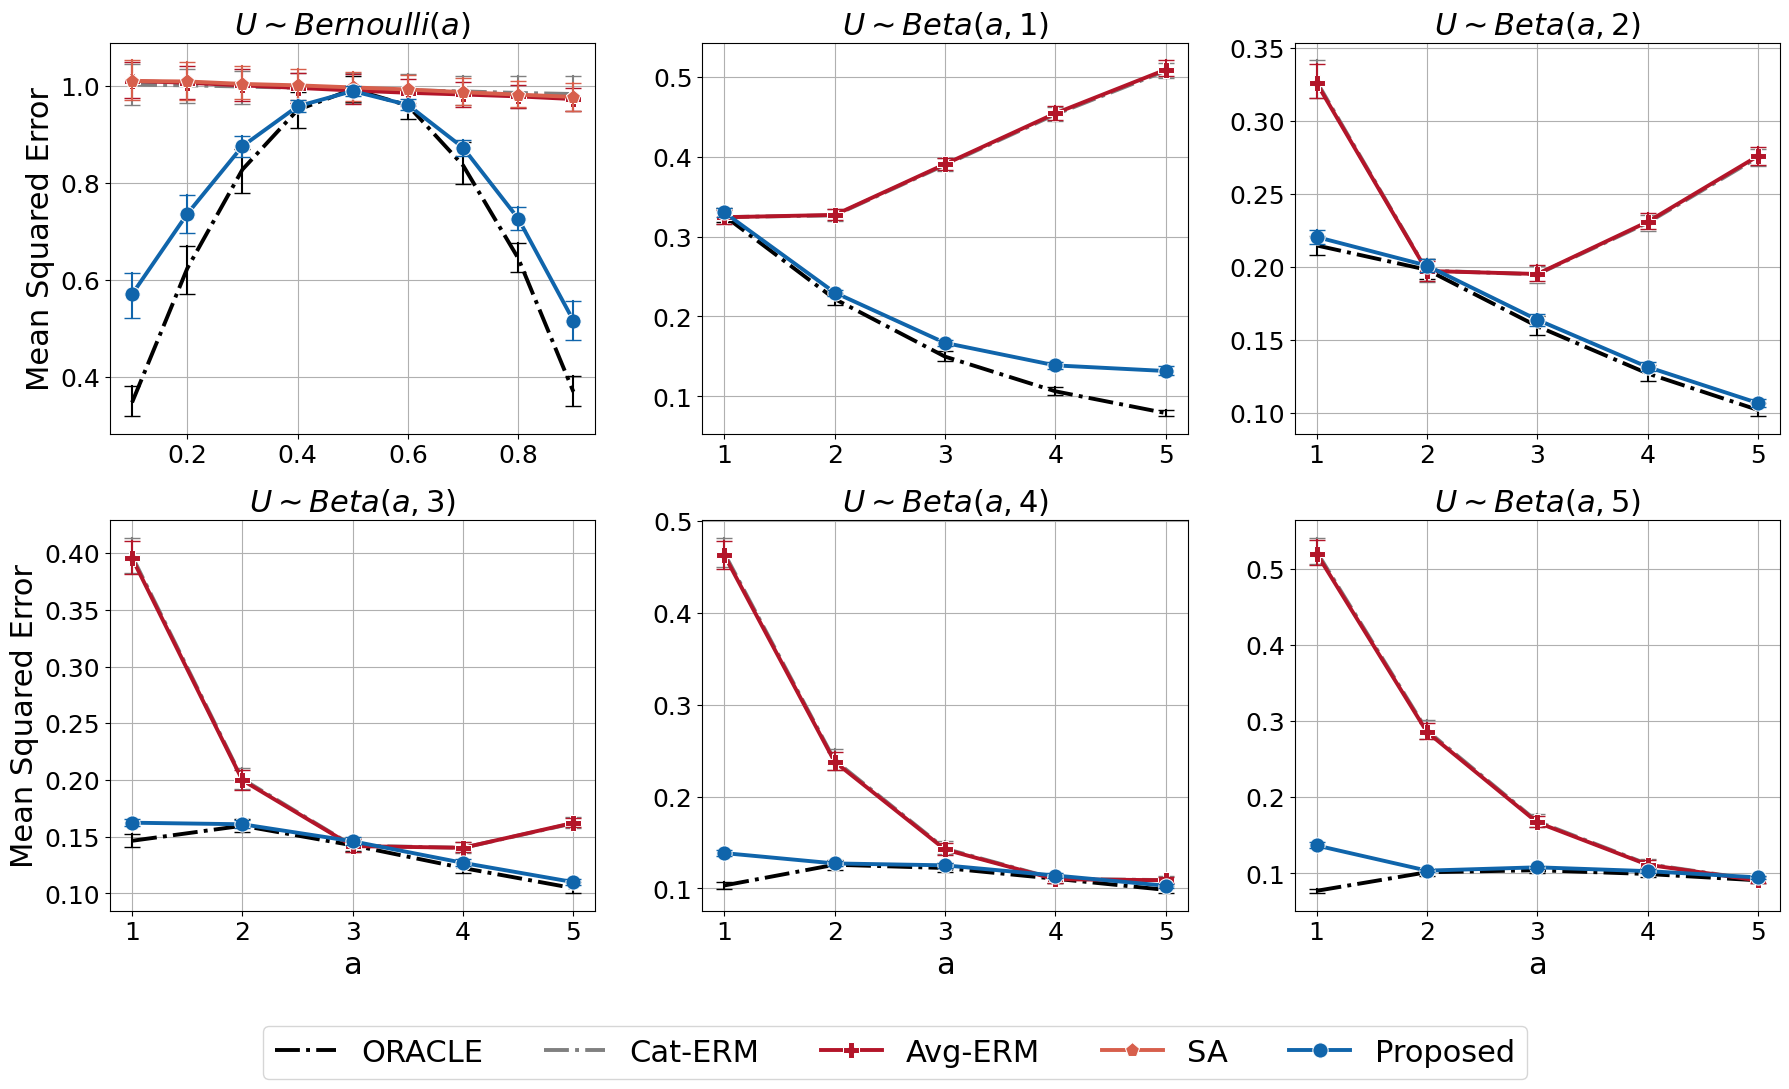

In [6]:
format_set = [
    {"color": "black", "linestyle": "dashdot", "marker": None},
    {"color": "grey", "linestyle": "dashdot", "marker": None},
    {"color": "#b31529", "linestyle": "solid", "marker": "P"},
    {"color": "#d75f4c", "linestyle": "solid", "marker": "p"},
    {"color": "#d7864c", "linestyle": "solid", "marker": "x"},
    {"color": "#3A93C3", "linestyle": "solid", "marker": "d"},
    {"color": "#1065ab", "linestyle": "solid", "marker": "o"},
]


tick_size = 18
label_size = 22
linewidth = 2.8
capsize = 6
markersize = 11
fig, axes = plt.subplots(2, 3, figsize=(18, 10))


style_dict = {
    "ORACLE": {
        "line_style": format_set[0]["linestyle"],
        "marker": format_set[0]["marker"],
        "color": format_set[0]["color"],
    },
    "Cat-ERM": {
        "line_style": format_set[1]["linestyle"],
        "marker": format_set[1]["marker"],
        "color": format_set[1]["color"],
    },
    "Avg-ERM": {
        "line_style": format_set[2]["linestyle"],
        "marker": format_set[2]["marker"],
        "color": format_set[2]["color"],
    },
    "SA": {
        "line_style": format_set[3]["linestyle"],
        "marker": format_set[3]["marker"],
        "color": format_set[3]["color"],
    },
    "Proposed": {
        "line_style": format_set[6]["linestyle"],
        "marker": format_set[6]["marker"],
        "color": format_set[6]["color"],
    },
}


for approach, style in style_dict.items():
    subset = all_summary[all_summary["approach"] == approach]
    sns.lineplot(
        data=subset.sort_values(by=["pU=0"]),
        x="pU=0",
        y="MSE",
        label=approach,
        color=style["color"],
        ax=axes[0, 0],
        legend=False,
        linestyle=style["line_style"],
        err_kws={"capsize": capsize},
        err_style="bars",
        marker=style["marker"],
        markersize=markersize,
        linewidth=linewidth,
    )


for approach, style in style_dict.items():
    subset = all_df[(all_df["approach"] == approach) & (all_df["b"] == 1)]
    sns.lineplot(
        data=subset.sort_values(by=["a"]),
        x="a",
        y="MSE",
        label=approach,
        color=style["color"],
        ax=axes[0, 1],
        legend=False,
        linestyle=style["line_style"],
        err_kws={"capsize": capsize},
        err_style="bars",
        marker=style["marker"],
        markersize=markersize,
        linewidth=linewidth,
    )


for approach, style in style_dict.items():
    subset = all_df[(all_df["approach"] == approach) & (all_df["b"] == 2)]
    sns.lineplot(
        data=subset.sort_values(by=["a"]),
        x="a",
        y="MSE",
        label=approach,
        color=style["color"],
        ax=axes[0, 2],
        legend=False,
        linestyle=style["line_style"],
        err_kws={"capsize": capsize},
        err_style="bars",
        marker=style["marker"],
        markersize=markersize,
        linewidth=linewidth,
    )


for approach, style in style_dict.items():
    subset = all_df[(all_df["approach"] == approach) & (all_df["b"] == 3)]
    sns.lineplot(
        data=subset.sort_values(by=["a"]),
        x="a",
        y="MSE",
        label=approach,
        color=style["color"],
        ax=axes[1, 0],
        legend=False,
        linestyle=style["line_style"],
        err_kws={"capsize": capsize},
        err_style="bars",
        marker=style["marker"],
        markersize=markersize,
        linewidth=linewidth,
    )


for approach, style in style_dict.items():
    subset = all_df[(all_df["approach"] == approach) & (all_df["b"] == 4)]
    sns.lineplot(
        data=subset.sort_values(by=["a"]),
        x="a",
        y="MSE",
        label=approach,
        color=style["color"],
        ax=axes[1, 1],
        legend=False,
        linestyle=style["line_style"],
        err_kws={"capsize": capsize},
        err_style="bars",
        marker=style["marker"],
        markersize=markersize,
        linewidth=linewidth,
    )


for approach, style in style_dict.items():
    subset = all_df[(all_df["approach"] == approach) & (all_df["b"] == 5)]
    sns.lineplot(
        data=subset.sort_values(by=["a"]),
        x="a",
        y="MSE",
        label=approach,
        color=style["color"],
        ax=axes[1, 2],
        legend=False,
        linestyle=style["line_style"],
        err_kws={"capsize": capsize},
        err_style="bars",
        marker=style["marker"],
        markersize=markersize,
        linewidth=linewidth,
    )

for i in range(2):
    for j in range(3):
        axes[i, j].grid()
        axes[i, j].tick_params(axis="both", which="major", labelsize=tick_size)
        if i == 0:
            axes[i, j].set_xlabel("")
        if j > 0:
            axes[i, j].set_ylabel("")

axes[1, 0].set_xlabel("a", fontsize=label_size)
axes[1, 1].set_xlabel("a", fontsize=label_size)
axes[1, 2].set_xlabel("a", fontsize=label_size)
axes[0, 0].set_ylabel("Mean Squared Error", fontsize=label_size)
axes[1, 0].set_ylabel("Mean Squared Error", fontsize=label_size)
axes[0, 0].set_title(r"$U\sim Bernoulli(a)$", fontsize=label_size)
axes[0, 1].set_title(r"$U\sim Beta(a,1)$", fontsize=label_size)
axes[0, 2].set_title(r"$U\sim Beta(a,2)$", fontsize=label_size)
axes[1, 0].set_title(r"$U\sim Beta(a,3)$", fontsize=label_size)
axes[1, 1].set_title(r"$U\sim Beta(a,4)$", fontsize=label_size)
axes[1, 2].set_title(r"$U\sim Beta(a,5)$", fontsize=label_size)


lines2, labels2 = axes[1, 2].get_legend_handles_labels()

fig.legend(
    lines2,
    labels2,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=5,
    fontsize=label_size,
)
fig.tight_layout()
plt.subplots_adjust(wspace=0.22, hspace=0.22)

plt.savefig("sim_multisource_regression_result.pdf", bbox_inches="tight")